In [ ]:
%load_ext autoreload
%autoreload 2
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import argparse
import modules.A_mat as A_mat
import modules.pramameters as pramameters
import modules.plotGraph as plotGraph
import modules.utils as utils
import modules.nn as mynn
import modules.evaluate as evaluate
import pandas as pd


printFlag= 1
plotFlag= 1

#Changeable parameters 
parser = argparse.ArgumentParser(description='Topology fitting parameters')
pramameters.add_arguments(parser)
paras= pramameters.read_arguments(parser)
device= paras.device if torch.cuda.is_available() else "cpu"
#preset
paras.modelLoad= "AA"
paras.epoches= 20000
paras.strains = 1

Epi= "SARS_H1N1_COVID" # sars, covid, H1N1

# Read the CSV file into a NumPy array
epiOData = np.genfromtxt(f'testData/test_data.csv', delimiter=',', skip_header=0)
popData = np.genfromtxt(f'testData/test_pop.csv', delimiter=',', skip_header=0)
popIdxData = np.genfromtxt(f'testData/test_pop_inx.csv', delimiter=',', skip_header=0)
popIdxData= [int(i) for i in popIdxData]
file_path = 'testData/Country_Population_final.csv'
data = pd.read_csv(file_path)
popName= data["Country"].tolist()
popIdxAll= data["idx"]
popCropArea= data["CropArea"].to_numpy()
popCity= data["CityPop"].to_numpy()
popAll= data["Population"].to_numpy()
curPopName= [popName[int(i)] for i in popIdxData]
# print(curPopName)
# scaling= popData[np.argmax(popData)]/popData
# print(scaling.shape)
print(epiOData.shape)
# epiOData= epiOData*scaling[None, :]
popData= popCity[popIdxData]#/(popCropArea[popIdxData]/1e4+1e-9)
epiData= epiOData.copy()/popData[None, :]#[np.argmax(popData)]
# epiData= epiOData.copy()/popData[np.argmax(popData)]*popCropArea[popIdxData][None, :]/1e5
epiData[1:, :]= epiData[1:, :]- epiData[:-1, :]
epiData[epiData<0]= 0
epiData= epiData.T

if Epi=="SARS_H1N1_COVID":
    paras.strains= 3
    epiData= np.stack([epiData[:, 80*0: 80*1], epiData[:, 80*1: 80*2], epiData[:, 80*2: 80*3]], axis= 1)
elif Epi== "SARS":
    epiData= np.stack([epiData[:, 80*0: 80*1]], axis= 1)
elif Epi== "H1N1":
    epiData= np.stack([epiData[:, 80*1: 80*2]], axis= 1)
elif Epi== "COVID":
    epiData= np.stack([epiData[:, 80*2: 80*3]], axis= 1)

mask= np.ones(epiData.shape)
mask= mask*popData[:, None, None]/1e3
print(popData.shape)
print(epiData.shape)
# epiData= epiData[:, None, :]
divide= torch.Tensor(epiData).to(device)
maskTensor= torch.Tensor(mask).to(device= device)
paras.n= divide.shape[0]
P= torch.Tensor(popData).to(device)
# print(epiOData.shape)
# print(popData.shape)
# print(popIdxData.shape)
# print(len(popName))

# plt.figure(figsize=(12, 4))
# plt.plot(epiData)

(240, 93)
(93,)
(93, 3, 80)


torch.Size([93, 3, 80])


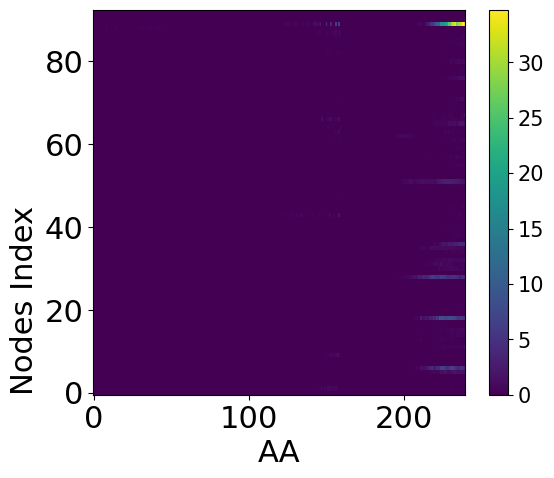

In [2]:
def rank_nodes_by_distance(G, source_node):
    # Get distances from the source_node to all other nodes
    distances = nx.single_source_shortest_path_length(G, source_node)
    # Sort nodes by distance from the source_node
    sorted_nodes = sorted(distances.items(), key=lambda x: x[1])
    # Return sorted nodes by their distance (excluding the distance values)
    return [node for node, _ in sorted_nodes]

print(divide.shape)

shapeY= divide.shape[0]
shapeX= divide.shape[1]*divide.shape[2]
divide2D= (epiData*mask).reshape(shapeY, shapeX)#.cpu().detach()
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
fontsize= 22
cmap= ax.pcolormesh(range(shapeX), range(shapeY), divide2D)
cbar= fig.colorbar(cmap)

cbar.ax.tick_params(labelsize= fontsize-7)

plt.ylabel("Nodes Index",  loc='bottom', fontsize= fontsize)

plt.xlabel(f"{paras.modelLoad}", fontsize= fontsize)

plt.gca().axes.get_xaxis().set_visible(True)

plt.gca().axes.get_yaxis().set_visible(True)

plt.tick_params(axis='both', labelsize=fontsize)

plt.show()

In [ ]:

timeHorizon= divide.shape[2]-1
if   paras.modelLoad=="AA":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AsA":
    myMatch= mynn.matchingAs(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="AB":
    myMatch= mynn.matchingA(timeHorizon+1, paras.strains, paras.n, channel= 5,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BA":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="BB":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisB(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)
elif paras.modelLoad=="infer2018":
    myMatch= mynn.matchingB(timeHorizon+1, paras.strains, paras.n,  device= device)
    myEpi= mynn.EpisA(input_dim= timeHorizon+1, num_heads= paras.strains, n= paras.n, device= device)

    
optimizer1 = torch.optim.Adam(myMatch.parameters(),lr=3e-4)#myMatch.parameters()
optimizer2 = torch.optim.Adam({myEpi.taus},lr=3e-4)
optimizer3 = torch.optim.Adam({myEpi.R0dTaus},lr=3e-4)
myloss= torch.nn.MSELoss(reduction='sum')
losses= []
if paras.modelLoad in ["infer2018", "AB", "BB"]:
    threshold_value= 0.1
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.taus.register_hook(hook)
    hook = mynn.ThresholdHook(threshold_value)
    myEpi.R0dTaus.register_hook(hook)
PreZs= []
# divideSum= divide.sum(dim= 2)
# divideSum= divideSum.sum(dim= 1)
# maskZmat= torch.zeros(divideSum.shape[0], divideSum.shape[0]).to(device)
# maskZmat[divideSum<1e-10, :]= 1
# maskZmat[:, divideSum<1e-10]= 1
# print(maskZmat)
maskDivide= maskTensor*divide
r2= maskDivide[:, 2, :].sum()/maskDivide[:, 2, :].sum()
r1= maskDivide[:, 2, :].sum()/maskDivide[:, 1, :].sum()
r0= maskDivide[:, 2, :].sum()/maskDivide[:, 0, :].sum()
ratio= torch.tensor([r0, r1, r2]).to(device=device)[None, :, None]/153

In [22]:
evaluateMeth= [evaluate.spectral_similarity, evaluate.pearson_correlation, evaluate.jaccard_similarity,evaluate.ROC_AUC, evaluate.PR_AUC]
zMatBound= A_mat.create_A_mat(torch.ones((paras.n, paras.n)).to(device)-torch.eye(paras.n).to(device), P)
# ratio = 1/153
print(ratio)
for j in tqdm(range(paras.epoches*24)):
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    optimizer3.zero_grad()
    inferZmat= myMatch(divide, paras.modelLoad)
    predSignal, signal, PreZ= myEpi(divide, inferZmat)
    predSignal= predSignal*maskTensor
    signal= signal*maskTensor
    loss= myloss(predSignal[:, :, 0:-1]*ratio ,signal[:, :, 1:]*ratio)/100 + torch.var(myEpi.taus, dim= 0).sum()\
            + torch.var(myEpi.R0dTaus, dim= 0).sum()
    if torch.isnan(loss).any():
        utils.log_print(printFlag, f"meet nan value at {j}")#
        break
    losses.append(loss.item())
    loss.backward(retain_graph=True)

    optimizer1.step()
    optimizer2.step()
    optimizer3.step()

tensor([[[1.0021],
         [0.0932],
         [0.0065]]], device='cuda:0')


  0%|          | 0/480000 [00:00<?, ?it/s]

100%|██████████| 480000/480000 [28:44<00:00, 278.40it/s]


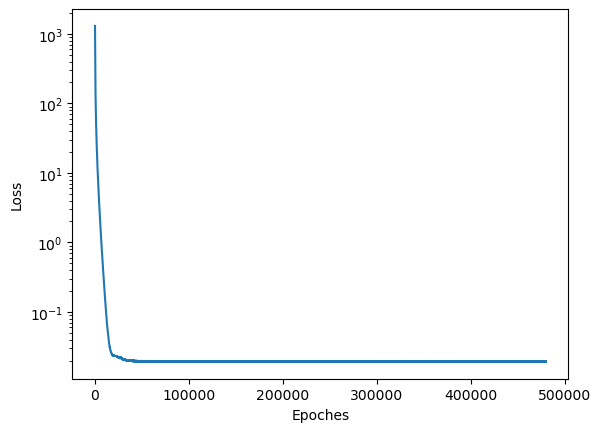

In [23]:
if plotFlag==1:
    plt.plot(losses)
    plt.yscale("log")
    plt.ylabel("Loss")
    plt.xlabel("Epoches")

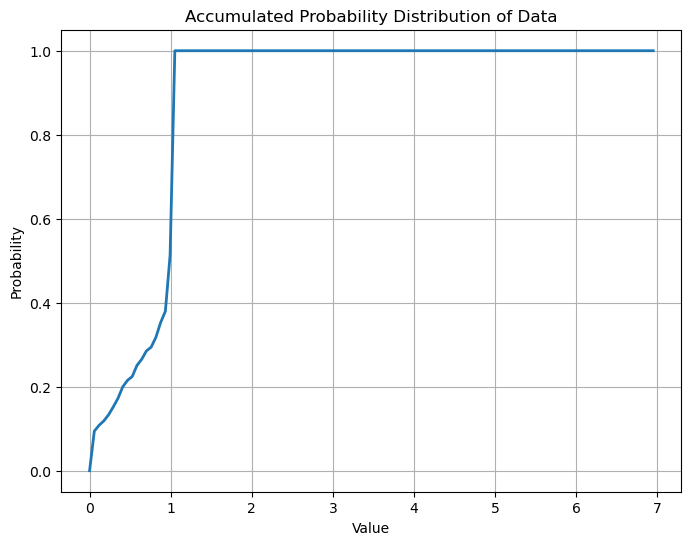

In [24]:
inferZmatNp= inferZmat.cpu().detach().numpy().squeeze()
pxs= []
pys= []
# Compute histogram
for i in range(120):
    px= i*(np.mean(inferZmatNp)-np.min(inferZmatNp))*3
    py= np.sum(inferZmatNp[inferZmatNp<px])/np.sum(inferZmatNp)
    pxs.append(px)
    pys.append(py)
    pass

# Plot the histogram as a probability distribution
plt.figure(figsize=(8, 6))
plt.plot(pxs, pys, linestyle='-', linewidth=2)
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title('Accumulated Probability Distribution of Data')
plt.grid(True)
plt.show()

In [33]:
printFlag= 1
# #save: A, preA, losses, taus, pretaus, R0s, preR0s, [errors]
utils.log_print(printFlag,1/(1.01+torch.abs(myEpi.taus)).T) # recoverry rate
utils.log_print(printFlag,(myEpi.R0dTaus).T)# transmission rate
#H1N1:(0.1677, 0.1849), Sars: (0.1630, 0.1578), Covid: (0.1873, 0.3838)
zMatBound= A_mat.create_A_mat(torch.ones((paras.n, paras.n)).to(device)-torch.eye(paras.n).to(device), P)
IMatrix= torch.eye(paras.n, device= device)
# print(inferZmat)
PreA= A_mat.reverse_A_mat(inferZmat, P)
PreA= PreA*P
PreA= PreA/torch.norm(PreA)

inferZmat= inferZmat/torch.norm(inferZmat)

utils.log_print(printFlag,torch.var(myEpi.taus, dim= 0))


tensor([[0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051, 0.1051,
         0.1051, 0.1051, 0.1051],
        [0.0575, 0.0575, 0.0575, 0.0575, 0.0575, 0.0575, 0.0575, 0.0575, 0.0575,
         0.0575, 0.0575, 0.0575, 0.0575, 0.0575, 0.0575, 0.0575, 0.0575, 0.

tensor([0.0000e+00, 1.6368e-04, 2.6845e-04, 2.7244e-04, 2.7355e-04, 2.3273e-04,
        1.1997e-03, 2.6715e-04, 2.4495e-04, 2.0771e-04, 2.5145e-04, 2.1421e-04,
        2.2090e-04, 2.7099e-04, 2.4793e-04, 2.2115e-04, 2.6554e-04, 2.6933e-04,
        1.3609e-03, 2.6898e-04, 2.6433e-04, 2.7397e-04, 2.7180e-04, 2.5595e-04,
        2.7365e-04, 2.6170e-04, 2.6437e-04, 2.6755e-04, 4.8756e-02, 2.7656e-04,
        2.4214e-04, 3.4637e-04, 2.6452e-04, 2.7140e-04, 2.3211e-04, 3.7920e-04,
        2.3978e-04, 2.6783e-04, 2.2852e-04, 2.7150e-04, 2.5925e-04, 2.4351e-04,
        2.5656e-04, 2.3197e-04, 1.8987e-04, 2.0666e-04, 2.0974e-04, 2.1069e-04,
        1.6388e-04, 2.6914e-04, 2.6697e-04, 2.9545e-04, 2.7233e-04, 2.6608e-04,
        2.7122e-04, 2.6445e-04, 2.6983e-04, 2.6394e-04, 2.6725e-04, 2.0526e-04,
        2.1705e-04, 2.5715e-04, 2.6460e-04, 2.4741e-04, 2.3471e-04, 2.6161e-04,
        1.5220e-04, 2.6307e-04, 2.6232e-04, 2.6527e-04, 2.5681e-04, 2.4922e-04,
        2.3084e-04, 2.6291e-04, 2.7077e-

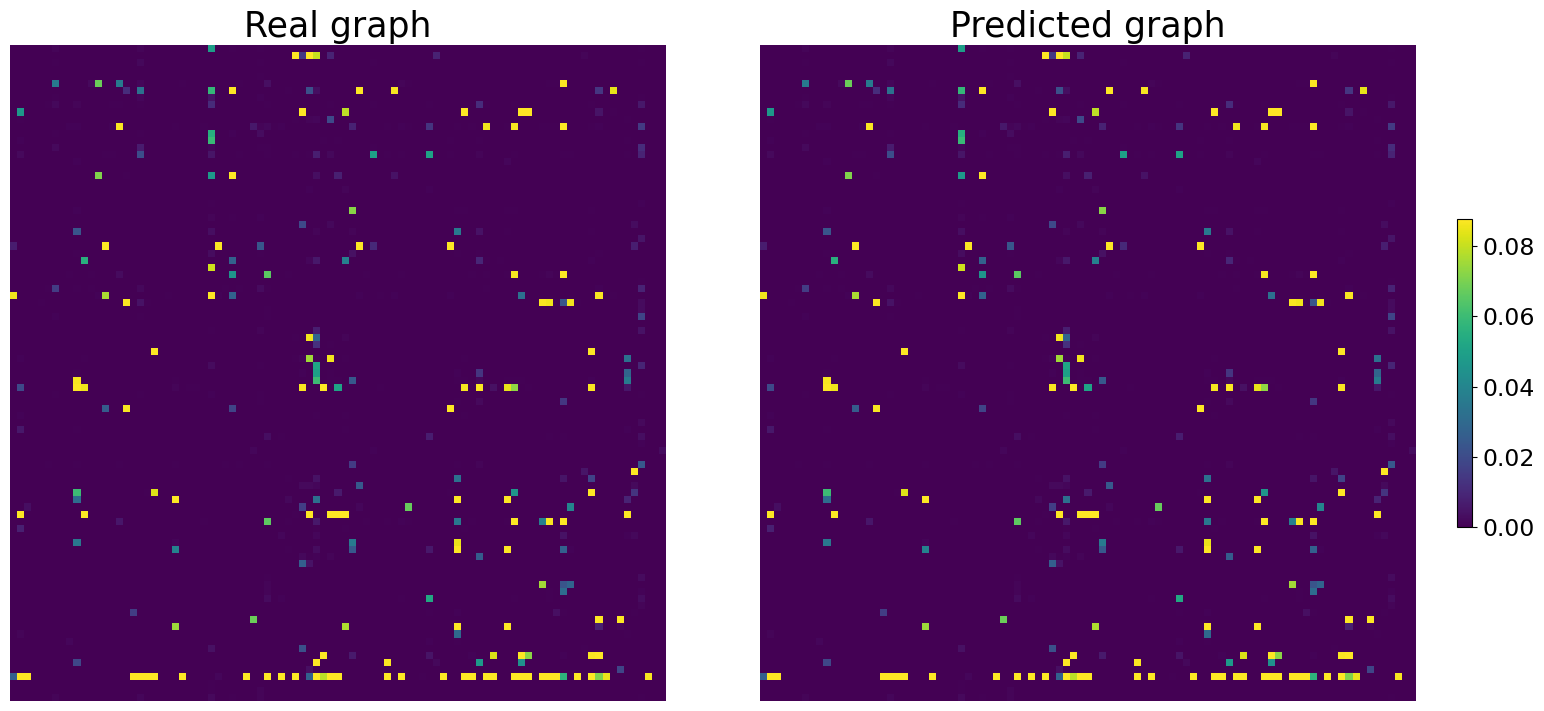

[16 84 58 57 20 17 19  3 74 21 39 24 33 37 52 79 53  4 91 90  2 75 69 56
 49 88 22 68 80 27 54 55 92 40 29  7 50 42 25 85 62 83 73 10 14 38 72 77
 34  8 61 59  0 78 45 12 13 26 31 23 60 46 41 65 76 30 70 15 43 44 51 18
 47 81  5 71 87  1 63 32 82 64 36 28 35 11 67  9  6 86 66 48 89]
['South Africa', 'Indonesia', 'Iraq', 'Pakistan', 'Egypt', 'Cameroon', 'Morocco', 'Burkina Faso', 'Kazakhstan', 'Albania', 'Slovakia', 'Croatia', 'Bosnia and Herzegovina', 'Moldova', 'Jordan', 'Uzbekistan', 'Kuwait', 'Tunisia', 'Lithuania', 'Latvia', 'Algeria', 'Azerbaijan', 'Colombia', 'Oman', 'Bahrain', 'China', 'Bulgaria', 'Paraguay', 'India', 'Hungary', 'Lebanon', 'United Arab Emirates', 'Armenia', 'Dominican Republic', 'Slovenia', 'Estonia', 'Saudi Arabia', 'Honduras', 'France', 'Malaysia', 'South Korea', 'Vietnam', 'Venezuela', 'Netherlands', 'Poland', 'Serbia', 'Uruguay', 'Ukraine', 'Romania', 'Finland', 'Japan', 'Qatar', 'Iceland', 'Belarus', 'Panama', 'Luxembourg', 'Norway', 'Greece', 'Austria', 'C

In [34]:
toShowTopology= inferZmat
print(inferZmat[0])
if plotFlag==1:
    plotGraph.plot_adjacenty(toShowTopology.cpu().detach().numpy(), [ toShowTopology.cpu().detach().numpy()])
sumDegree= toShowTopology.cpu().detach().numpy().sum(axis= 1)
rankedPreAdegree= np.argsort(sumDegree)
print(rankedPreAdegree)
print([curPopName[i] for i in rankedPreAdegree])
print(curPopName)

(93,)


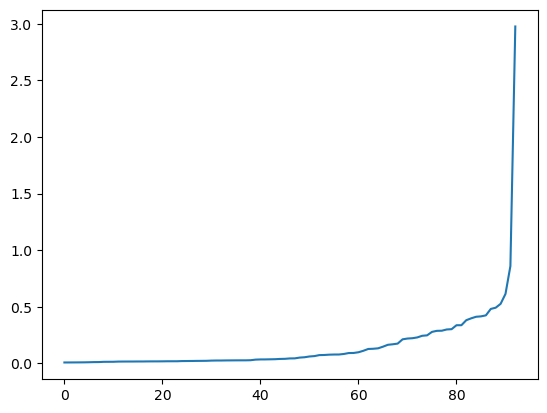

In [35]:
print(popData.shape)
plt.plot(sumDegree[rankedPreAdegree])

In [44]:
print(curPopName.index("United States"))

89


torch.Size([93, 3, 80])


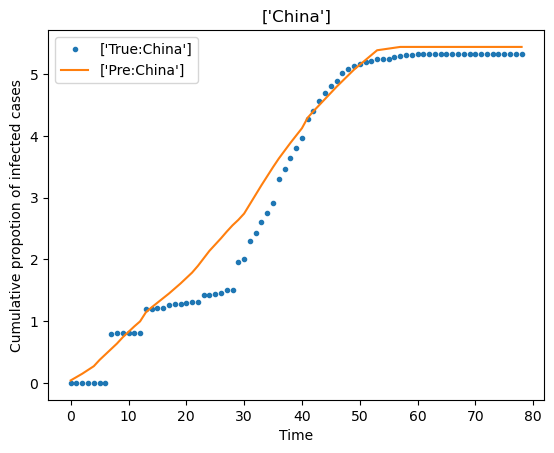

In [37]:
if plotFlag==1:
    node= [88]# -28
    refEpi= np.cumsum(signal[node, 0, 1:].squeeze().T.cpu().detach().numpy(), axis= 0)
    preEpi= np.cumsum(predSignal[node, 0, 1:].squeeze().T.cpu().detach().numpy(), axis= 0)
    plt.plot(refEpi, ".", label=["True:"+curPopName[i] for i in node])
    plt.plot(preEpi, label= ["Pre:"+curPopName[i] for i in node])
    plt.title(f"{[curPopName[i] for i in node]}")
    plt.xlabel("Time")
    plt.ylabel("Cumulative propotion of infected cases")
    plt.legend()
    print(signal.shape)


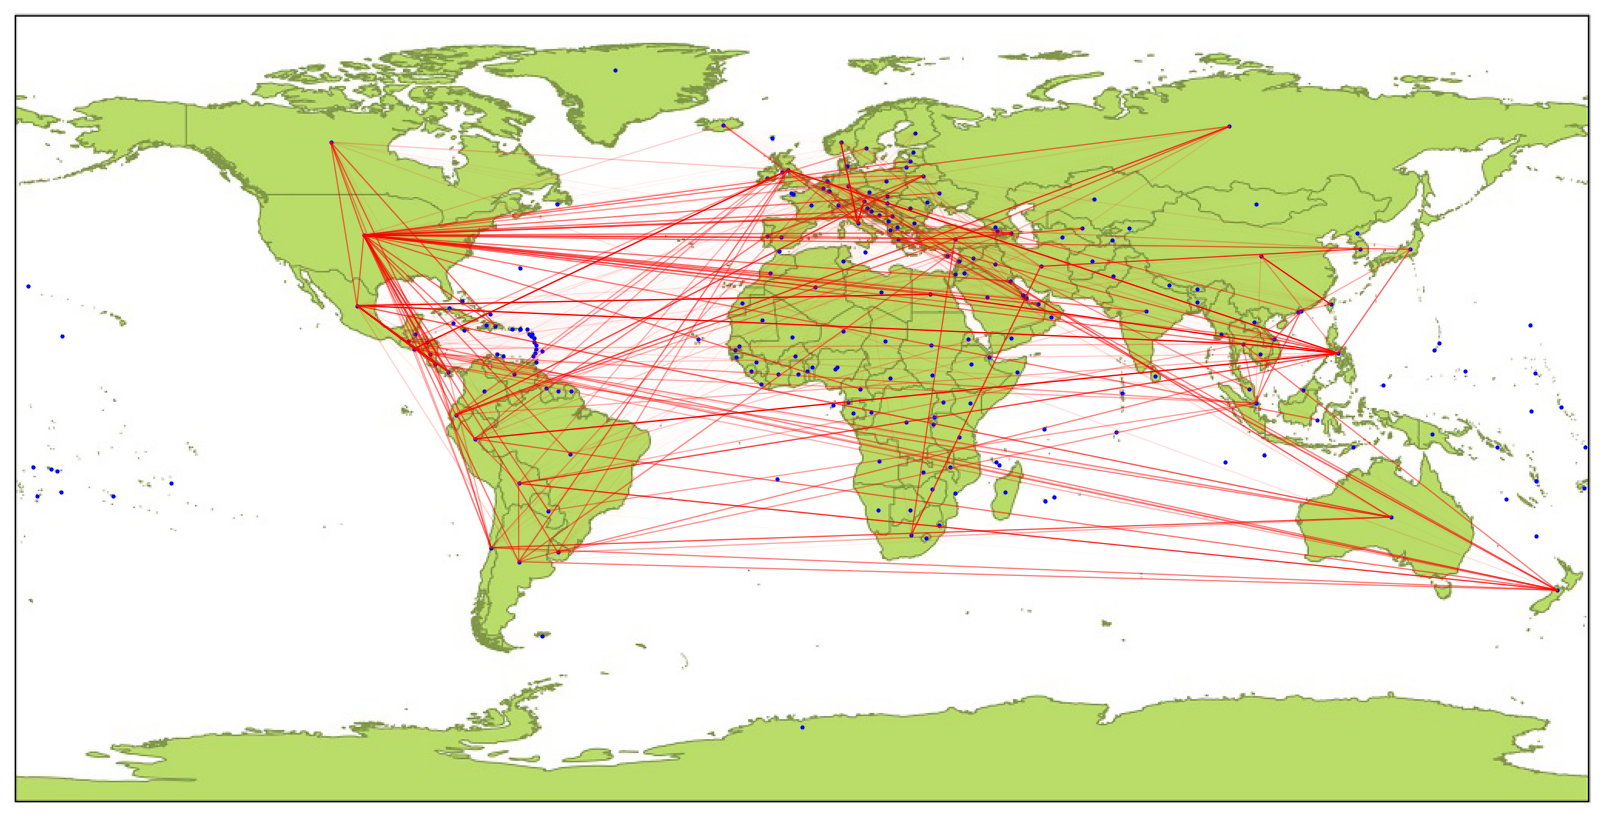

In [38]:
popIdxDataNp= np.array(popIdxData, dtype= "int")
def plot_on_map(PreANp, lineWeightRatio= 10):
    plt.figure(figsize=(10.28*2, 5.18*2))
    coordinatesArrayTmp= np.stack([data["loc_x"].to_numpy(), data["loc_y"].to_numpy()], axis= 1)
    img = plt.imread("WorldEqdc.jpg")
    plt.imshow(img)
    coordinatesArray= coordinatesArrayTmp.copy()
    coordinatesArray[:, 1]= 2.835*coordinatesArrayTmp[:, 1]+1028/2
    coordinatesArray[:, 0]= -2.835*coordinatesArrayTmp[:, 0]+518/2
    plt.scatter(coordinatesArray[:, 1], coordinatesArray[:, 0], color='blue', s=4, label="Locations")
    # for i in range(len(popName)):
    #     plt.text(coordinatesArray[i, 1] + 0.1,
    #             coordinatesArray[i, 0] + 0.1, f"{popName[i]}", fontsize=10, color='black')  # Annotate points
    for i in range(PreANp.shape[0]):
        for j in range(i + 1, PreANp.shape[1]):  # Only upper triangle (undirected graph)
            if (PreANp[j, i]+PreANp[i, j])/2 > 1e-5 :# Only plot edges with weight > 0
                weight = (PreANp[j, i]+PreANp[i, j])/2
                plt.plot(
                    [coordinatesArray[popIdxDataNp[i], 1], coordinatesArray[popIdxDataNp[j], 1]],
                    [coordinatesArray[popIdxDataNp[i], 0], coordinatesArray[popIdxDataNp[j], 0]],
                    color='red', alpha=min((weight)*lineWeightRatio, 1), linewidth= 1
                )
    plt.axis('off')
plot_on_map(PreA.cpu().detach().numpy(), 20)

0.0


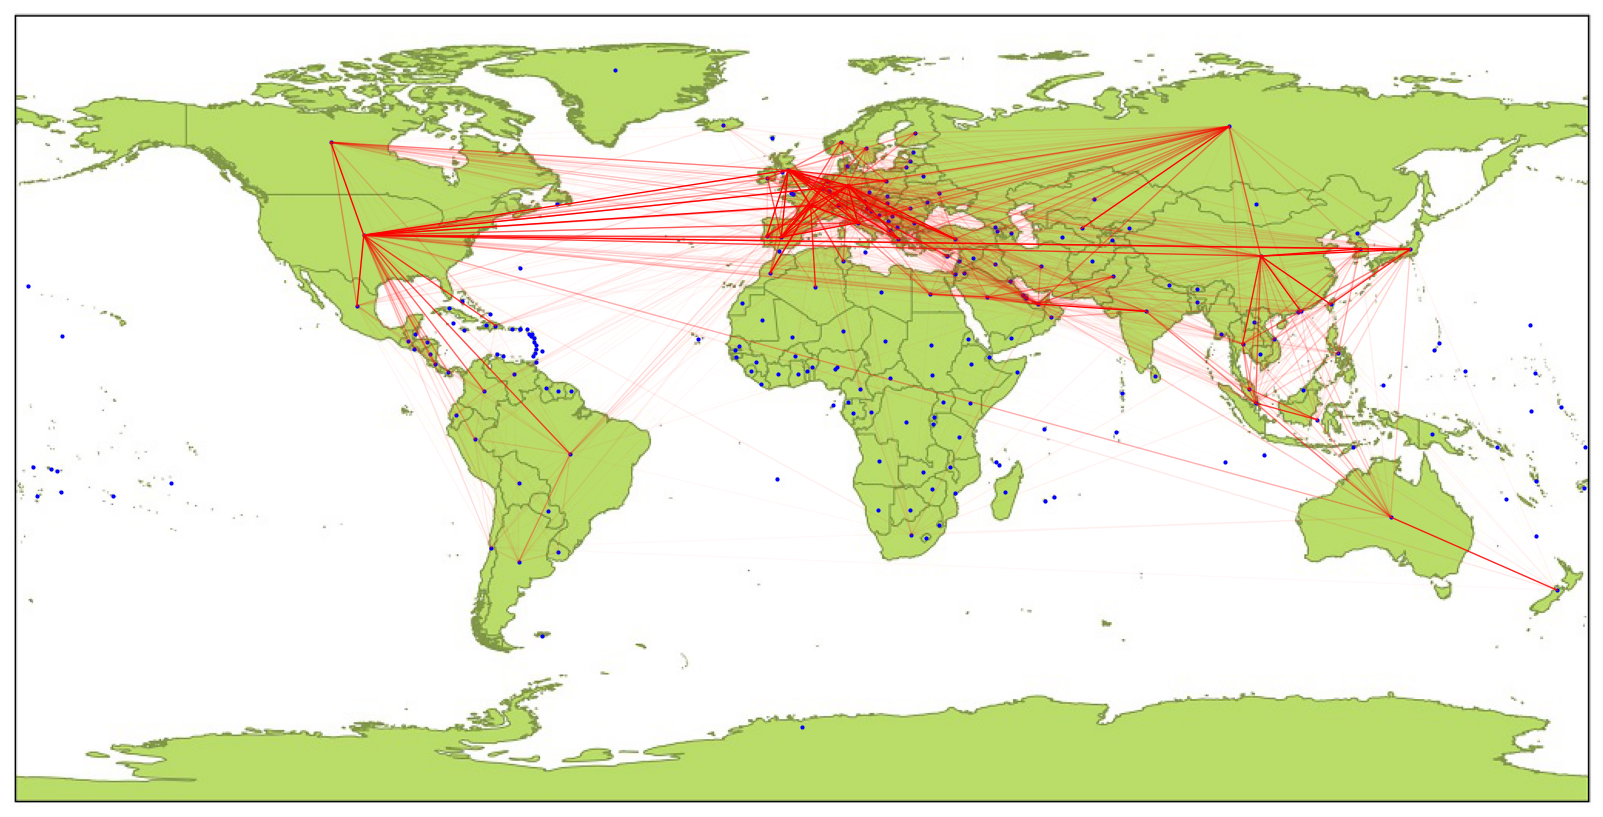

In [42]:
Adj = np.genfromtxt('empirical_data/Flights_adj.csv', delimiter=',', skip_header= 0)
np.fill_diagonal(Adj, 0)
print(np.sum(Adj-Adj.T))
Adj = Adj
AdjCur= Adj[ popIdxDataNp,:]
AdjCur= AdjCur[ :,popIdxDataNp]
AdjCur= AdjCur
AdjCur= AdjCur/np.linalg.norm(AdjCur)
AdjCurTen= torch.tensor(AdjCur).to(device)

plot_on_map(AdjCur, lineWeightRatio= 20)

In [56]:
randA= torch.rand((paras.n, paras.n)).to(device)
randA= randA/torch.norm(randA)
print(evaluate.pearson_correlation(randA, AdjCurTen))
print(evaluate.pearson_correlation(PreA, AdjCurTen))
print(evaluate.jaccard_similarity(randA, AdjCurTen))
print(evaluate.jaccard_similarity(PreA, AdjCurTen))
print(evaluate.spectral_similarity(randA, AdjCurTen))
print(evaluate.spectral_similarity(PreA, AdjCurTen))

tensor(-0.0117, device='cuda:0', dtype=torch.float64)
tensor(0.1171, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(0.0865, device='cuda:0', dtype=torch.float64)
tensor(0.0513, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)
tensor(-0.4812, device='cuda:0', dtype=torch.float64)
tensor(-0.3416, device='cuda:0', dtype=torch.float64, grad_fn=<DivBackward0>)


In [ ]:
fileName= f"{paras.modelLoad}/{paras.modelLoad}_{Epi}_{paras.strains}_{paras.n}" #SARS_H1N1_COVID

np.savez("results/"+fileName+".npz", A= AdjCurTen.cpu().detach(), Apre= PreA.cpu().detach(),
         loss= losses, tausP= myEpi.taus.cpu().detach(), 
         r0sP= (myEpi.R0dTaus*myEpi.taus).cpu().detach(), signal= signal.cpu().detach(), predSignal= predSignal.cpu().detach())